# Import and setup


In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from mop_model import MoPModel as MoP_raw, MoPConfig


# Trainning and evaluation functions

In [202]:
def train_and_evaluate_trial_mop(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoP model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    config = MoPConfig(
        input_dim=X_train.shape[1],
        output_dim=2,
        intermediate_dim=params['intermediate_dim'],
        layers=params['layers']
    )
    model = MoP_raw(config).to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        # MoP expects a sequence dimension
        y_pred, usage_losses, entropy_loss = model(X_train_tensor.unsqueeze(1))
        y_pred = y_pred.squeeze(1)
        
        # MoP auxiliary losses can be added here for more robust training
        class_loss = criterion(y_pred, y_train_tensor)
        total_loss = class_loss # For simplicity, we only use class_loss for early stopping
        
        total_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, _, _ = model(X_val_tensor.unsqueeze(1))
            val_loss = criterion(y_val_pred.squeeze(1), y_val_tensor)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _, _ = model(X_val_tensor.unsqueeze(1))
        y_pred_tensor = y_pred_tensor.squeeze(1)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'intermediate_dim': params['intermediate_dim'],
            'layers': str(params['layers']), # Convert list to string for display
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


# Data Loading and Hyperparameter definition

In [203]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'input_mop_original.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False) 
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_mop_original.csv' not found. Please ensure the correct data file is present.")

# --- 2. Define the Best Hyperparameters ---
best_params = {
    'intermediate_dim': 64,
    'layers': ['0,8,16', '0,16,32', '0,8,16']
}
print(f"\n🔹 Using best hyperparameters: {best_params}")

# --- 3. Prepare the Final Model ---
# Combine training and validation data for final training
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best model on combined Train+Validation data...")

# Create the final model instance with the best parameters
final_config = MoPConfig(
    input_dim=X_train_val.shape[1],
    output_dim=2,
    intermediate_dim=int(best_params['intermediate_dim']),
    layers=best_params['layers']
)
final_model = MoP_raw(final_config)


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (1297, 24)

🔹 Using best hyperparameters: {'intermediate_dim': 64, 'layers': ['0,8,16', '0,16,32', '0,8,16']}

Retraining the best model on combined Train+Validation data...


# Run grid search and final evaluation

In [204]:
# --- 1. Train the final model ---
# We reuse the evaluation function as a training function here
final_results = train_and_evaluate_trial_mop(
    best_params,
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

# --- 2. Print the final performance metrics on the test set ---
print("\n\n" + "="*40 + "\n✅ FINAL MODEL PERFORMANCE ON TEST SET\n" + "="*40)
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")

# --- 3. Save the final trained model ---
model_save_path = 'best_mop_rfe_model.pth'
torch.save(final_model.state_dict(), model_save_path)
print(f"\n✅ Best MoP model saved to '{model_save_path}'")




✅ FINAL MODEL PERFORMANCE ON TEST SET
  - Accuracy:    0.7482
  - ROC-AUC:     0.8070
  - F1-Score:    0.7619
  - Precision:   0.7273
  - Recall:      0.8000
  - Cohen Kappa: 0.4960

✅ Best MoP model saved to 'best_mop_rfe_model.pth'




🚀 Starting SHAP Analysis

--- Analyzing Overall MoP Model ---

SHAP Beeswarm Plot (Impact on each prediction)


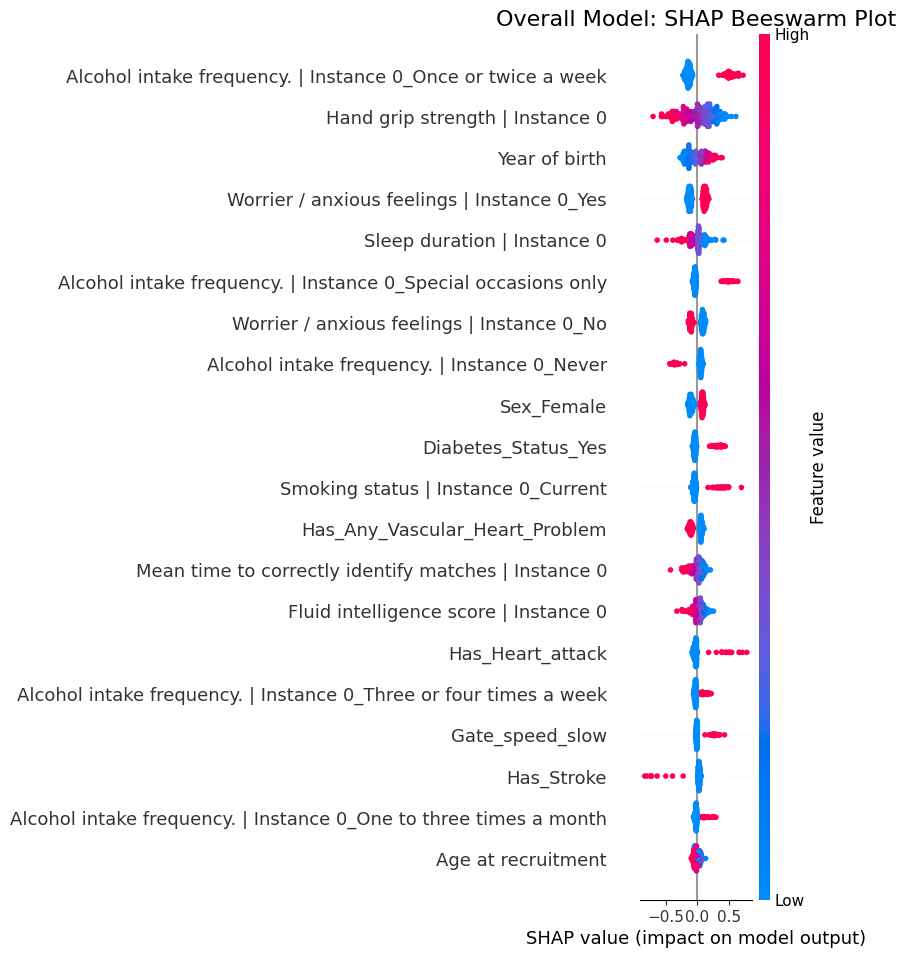


Mean Absolute SHAP Values (Overall Importance)


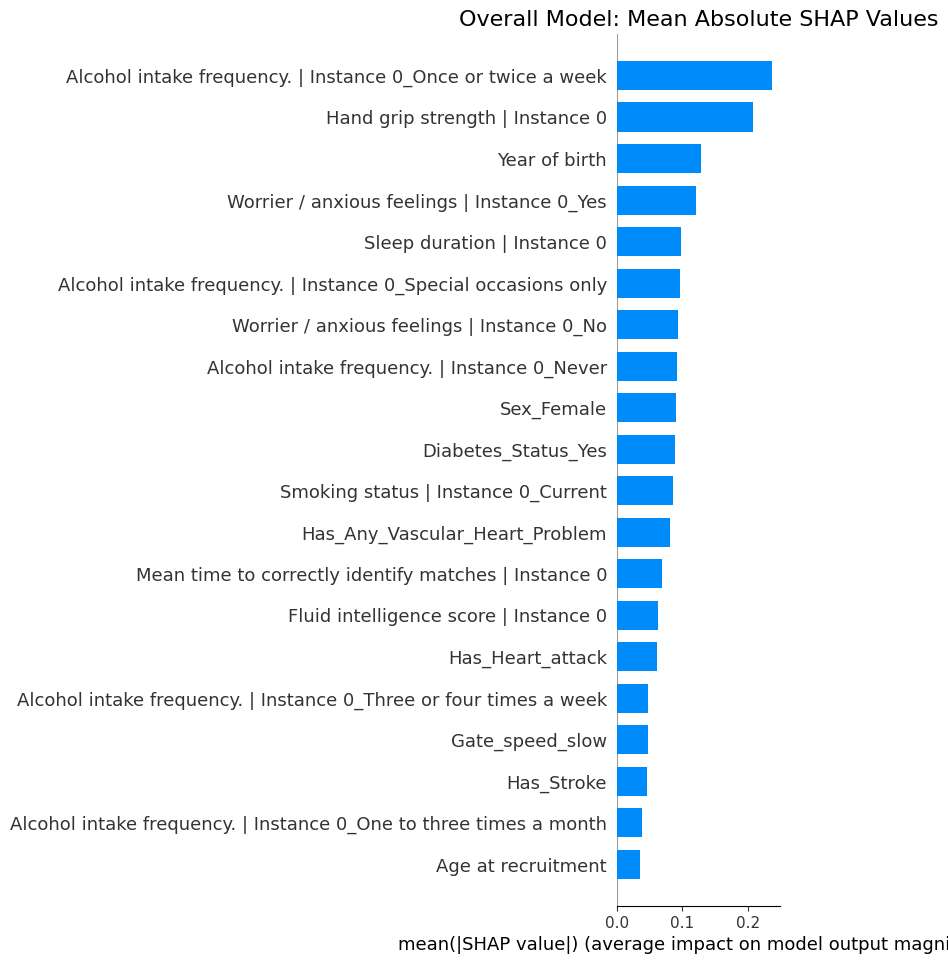



🕵️ Analyzing Expert Specializations

--- SHAP Analysis for data routed to Layer 1, Expert 2 ---

SHAP Beeswarm Plot (Layer 1, Expert 2)


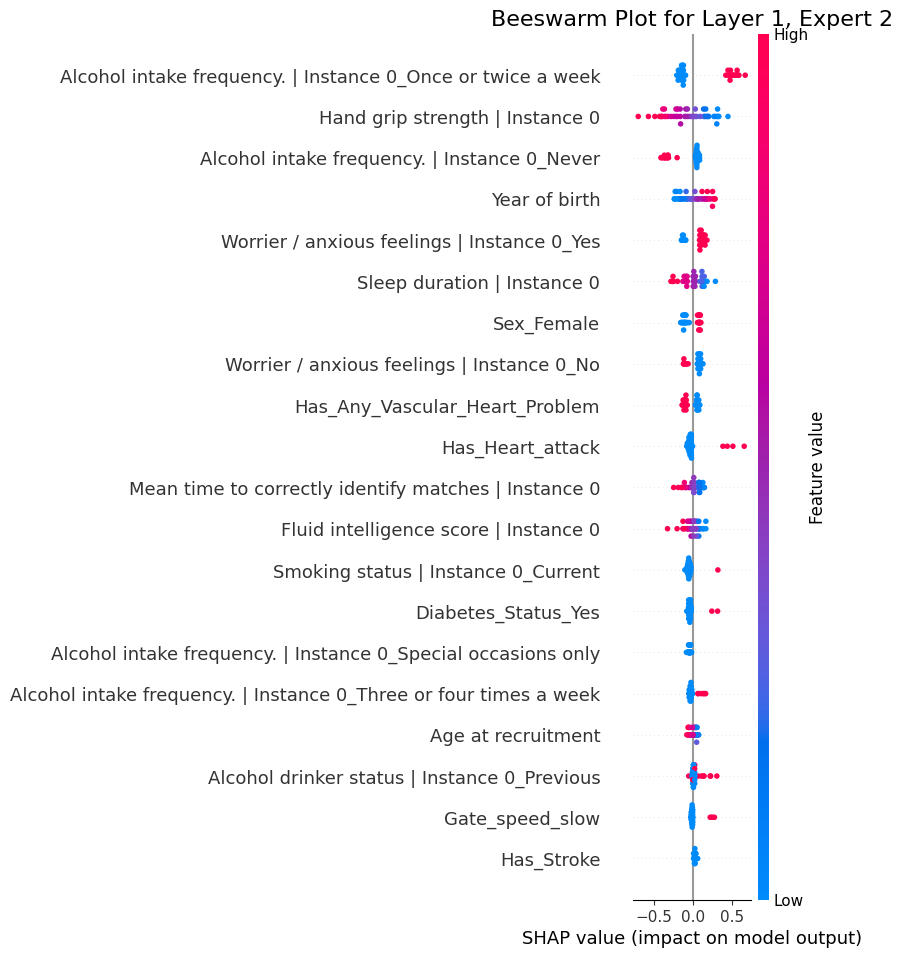


Mean Absolute SHAP Values (Layer 1, Expert 2)


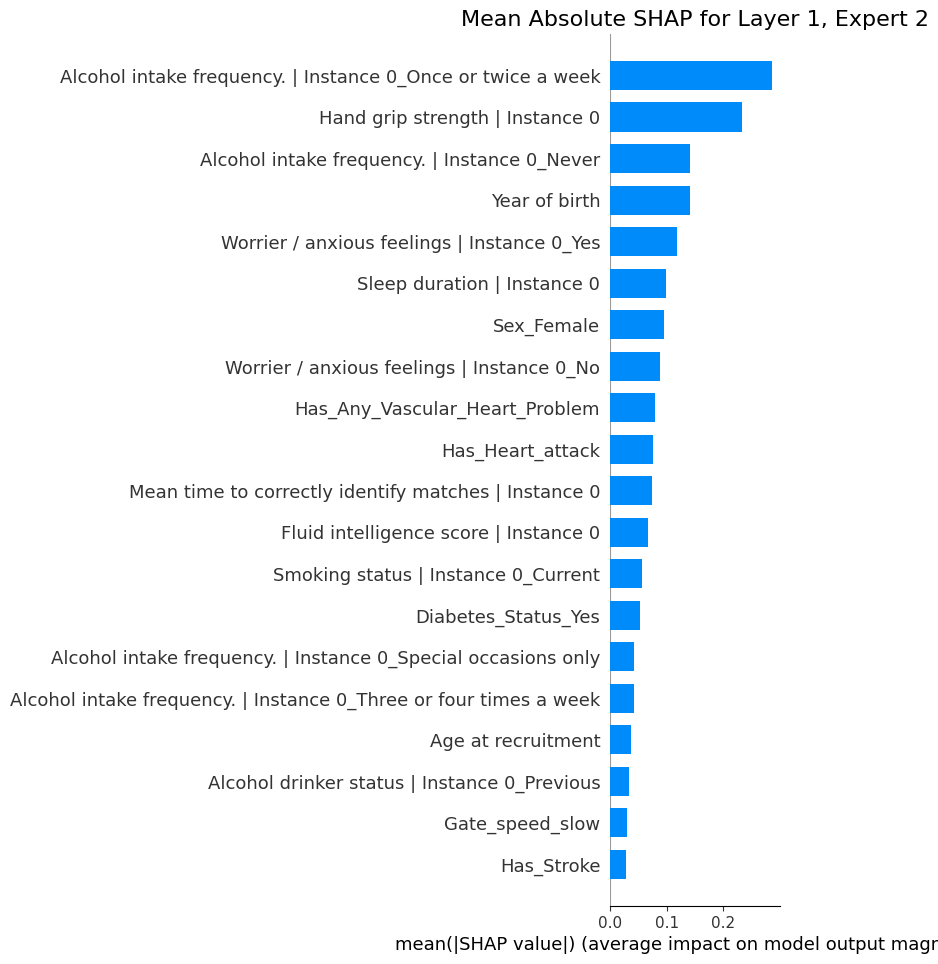


--- SHAP Analysis for data routed to Layer 1, Expert 3 ---

SHAP Beeswarm Plot (Layer 1, Expert 3)


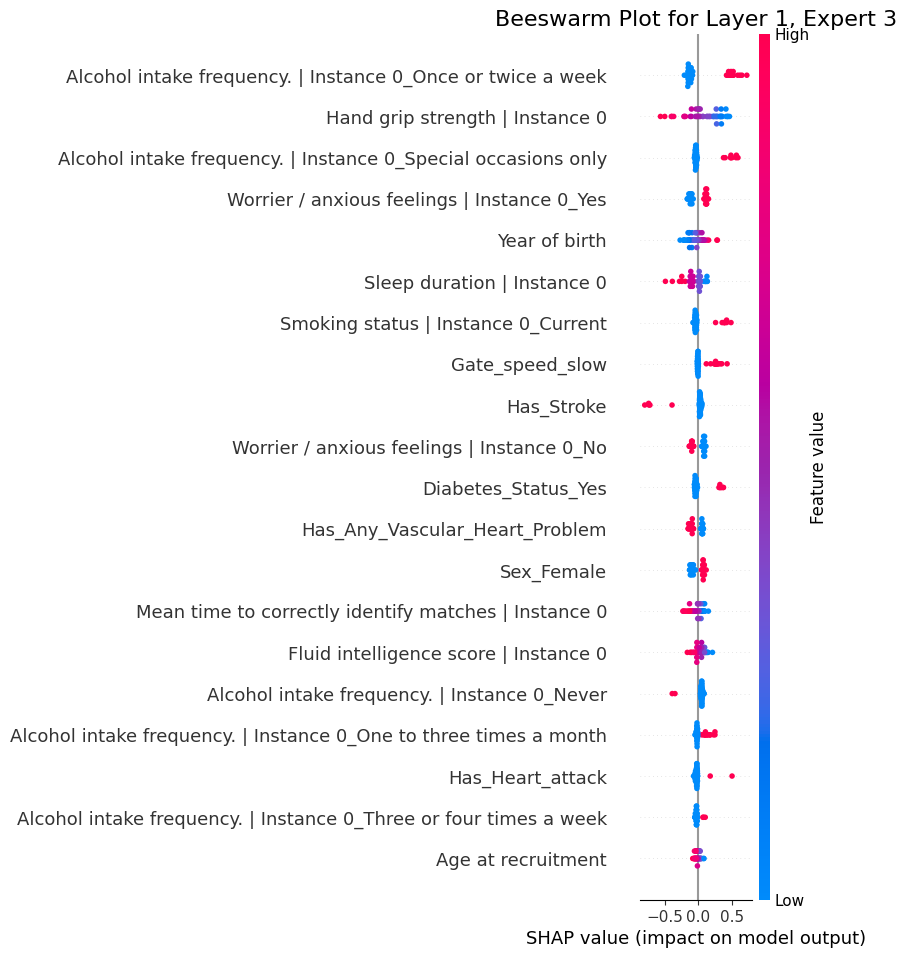


Mean Absolute SHAP Values (Layer 1, Expert 3)


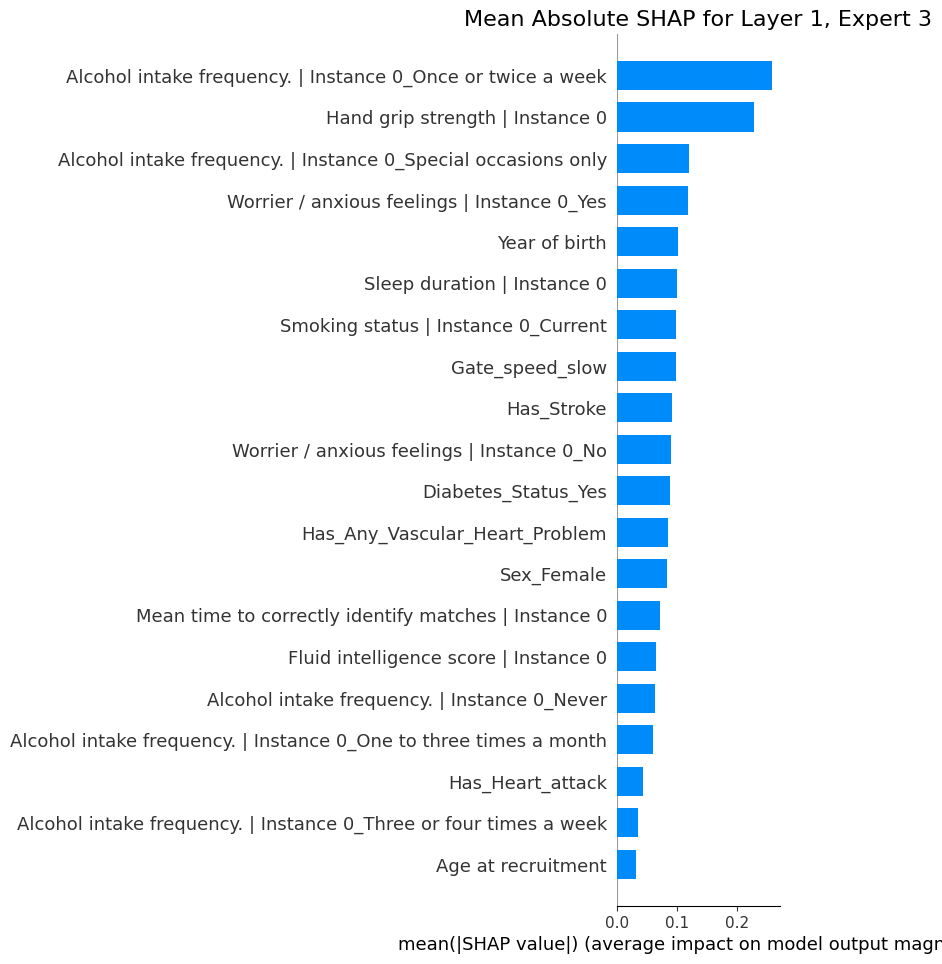


--- SHAP Analysis for data routed to Layer 2, Expert 2 ---

SHAP Beeswarm Plot (Layer 2, Expert 2)


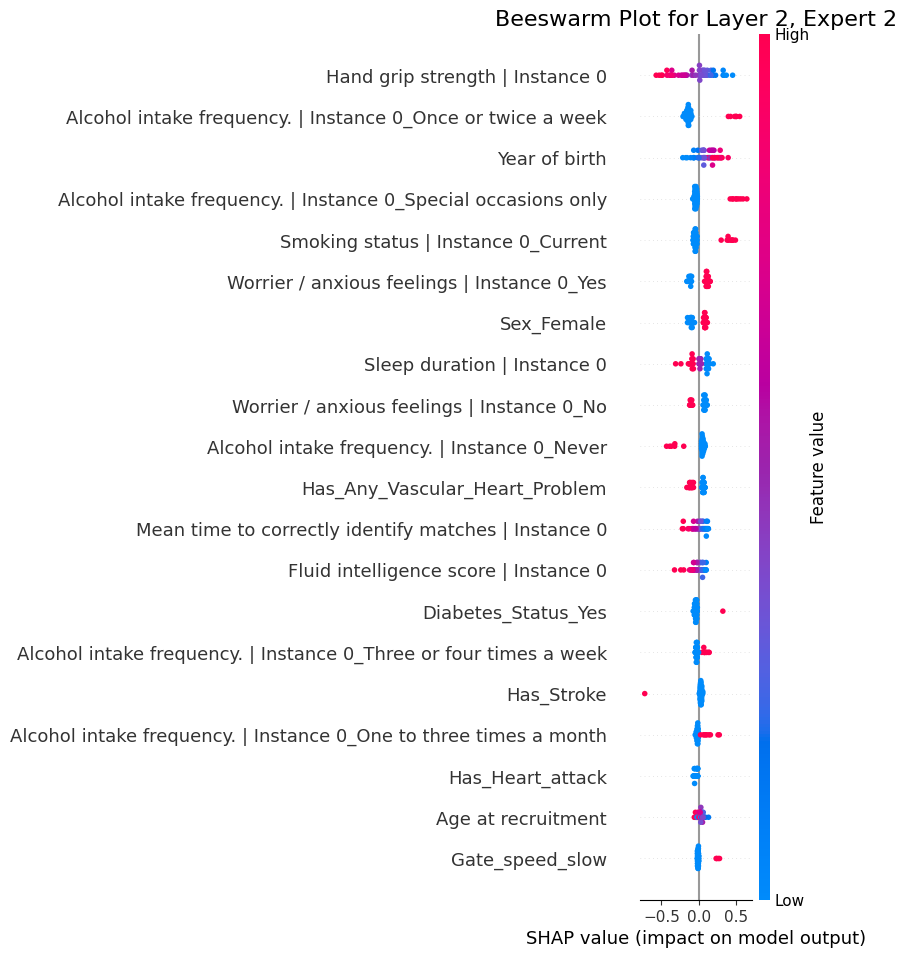


Mean Absolute SHAP Values (Layer 2, Expert 2)


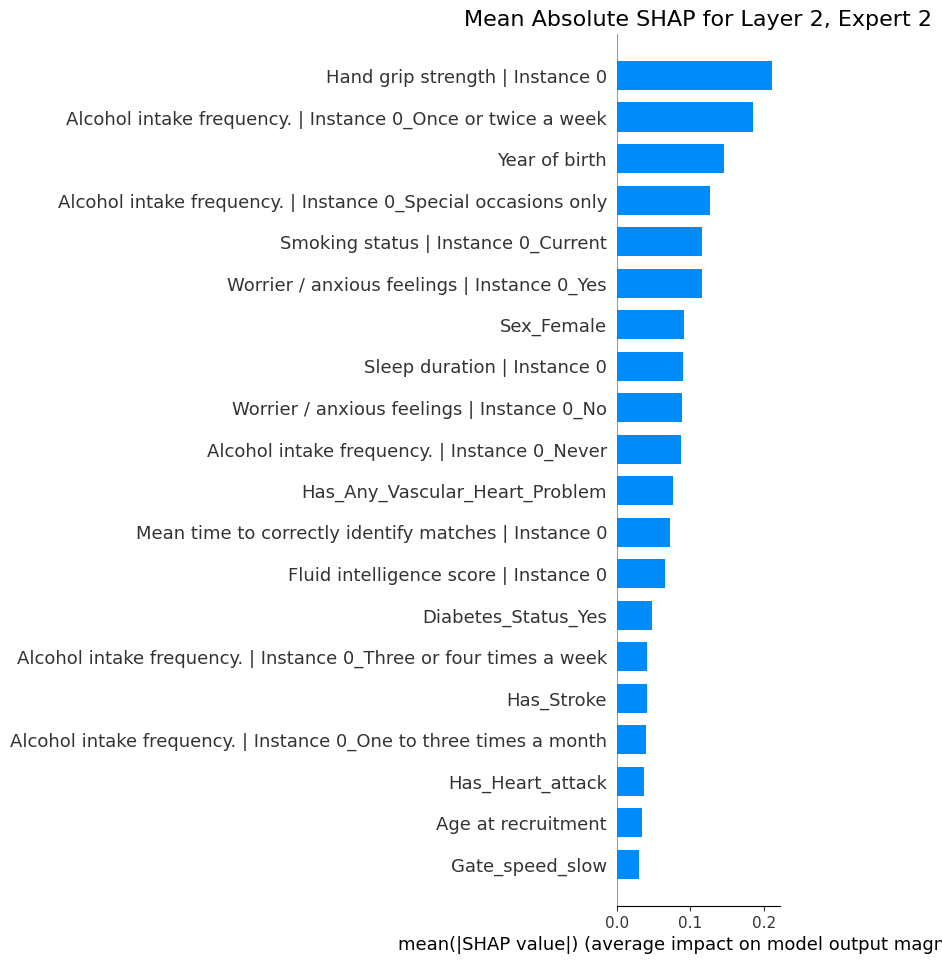


--- SHAP Analysis for data routed to Layer 2, Expert 3 ---

SHAP Beeswarm Plot (Layer 2, Expert 3)


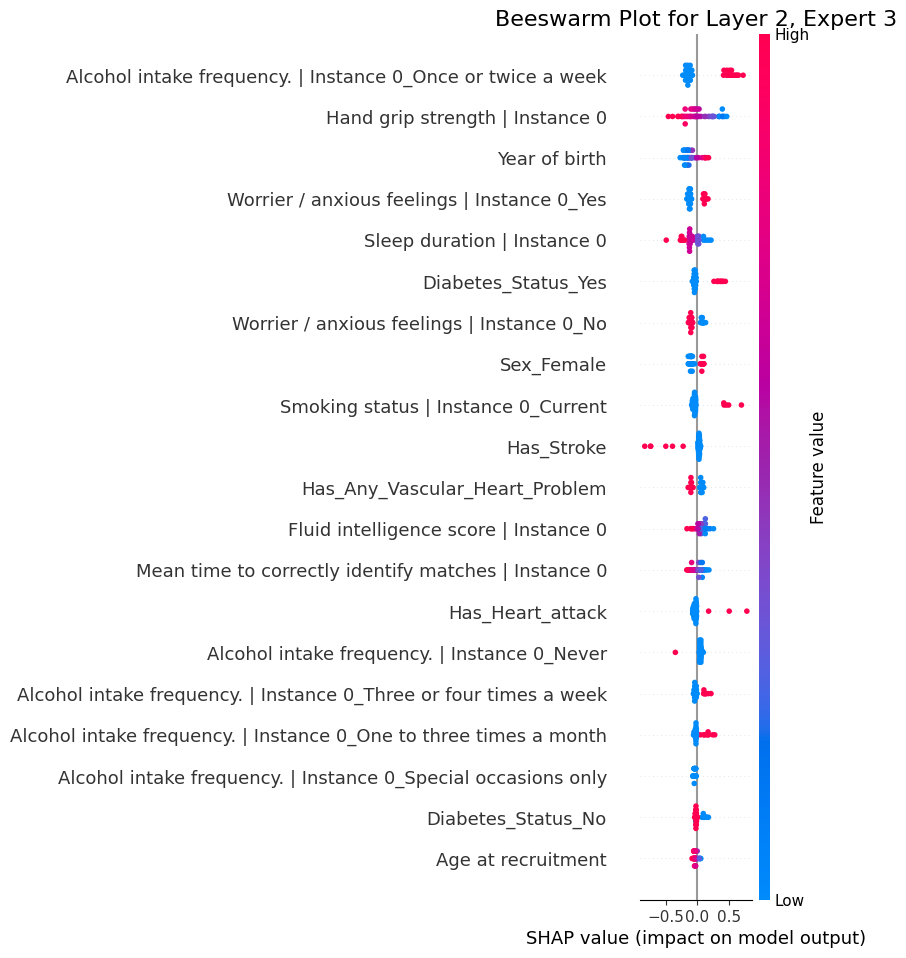


Mean Absolute SHAP Values (Layer 2, Expert 3)


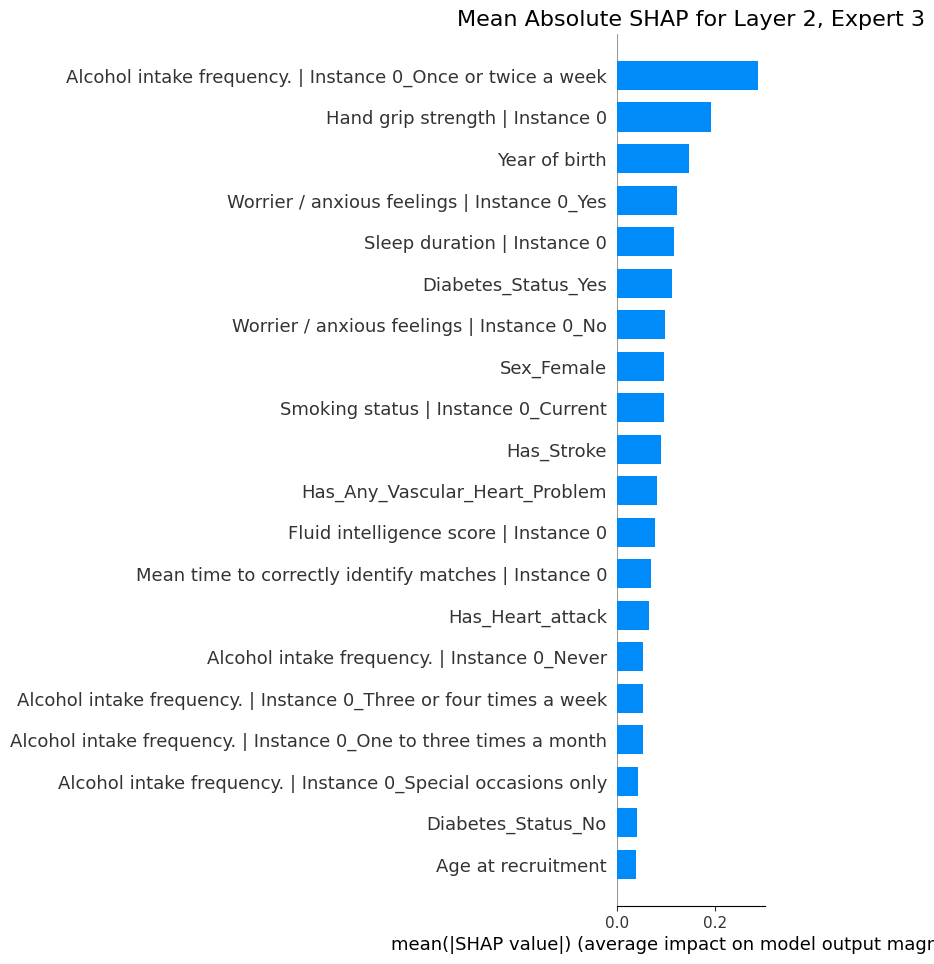


--- SHAP Analysis for data routed to Layer 3, Expert 2 ---

SHAP Beeswarm Plot (Layer 3, Expert 2)


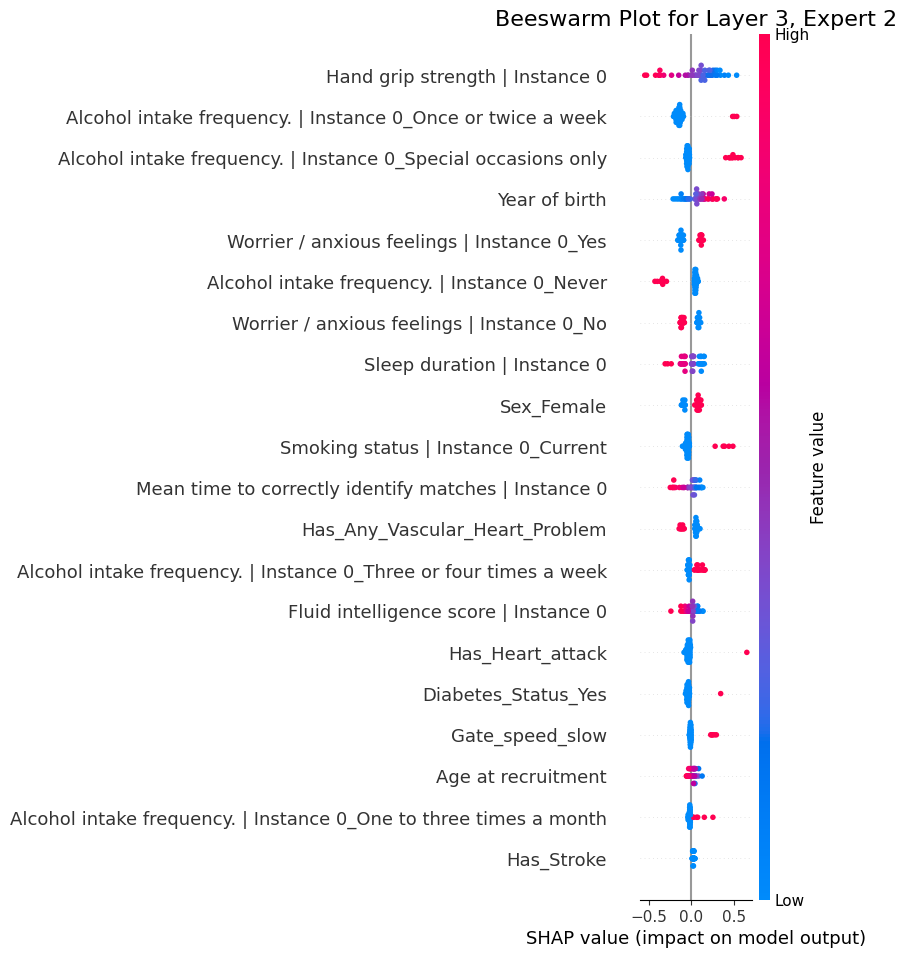


Mean Absolute SHAP Values (Layer 3, Expert 2)


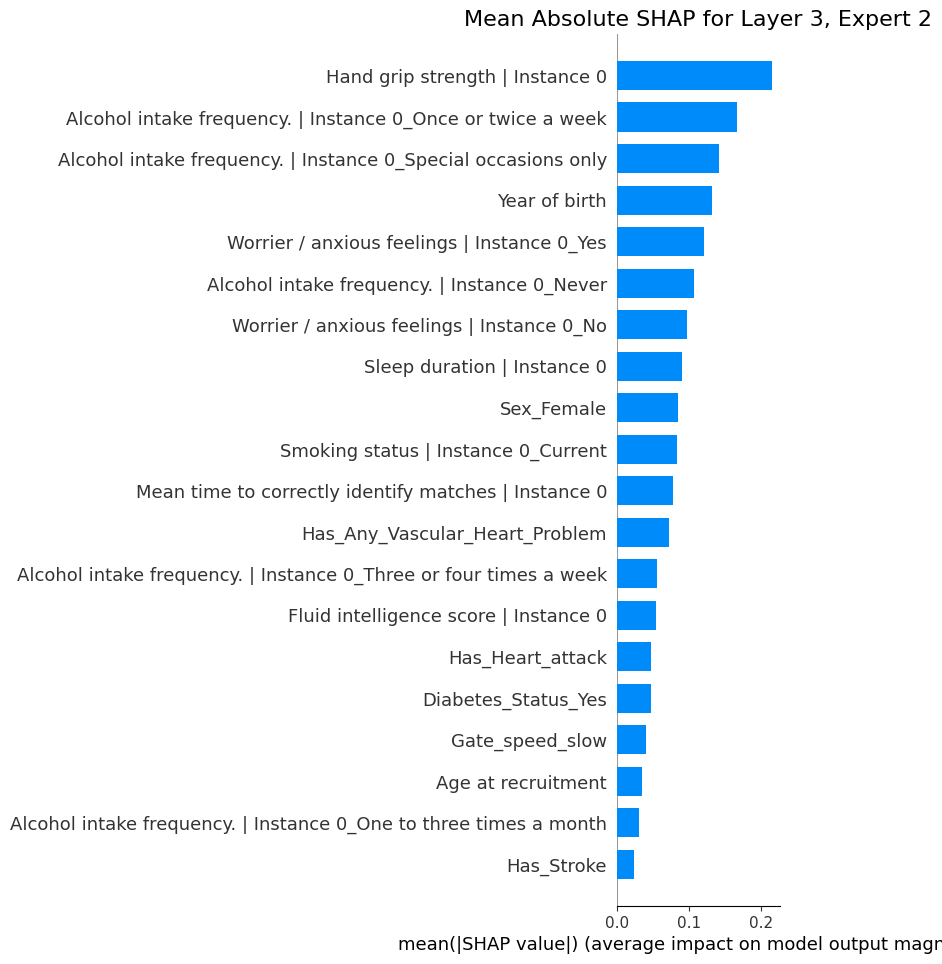


--- SHAP Analysis for data routed to Layer 3, Expert 3 ---

SHAP Beeswarm Plot (Layer 3, Expert 3)


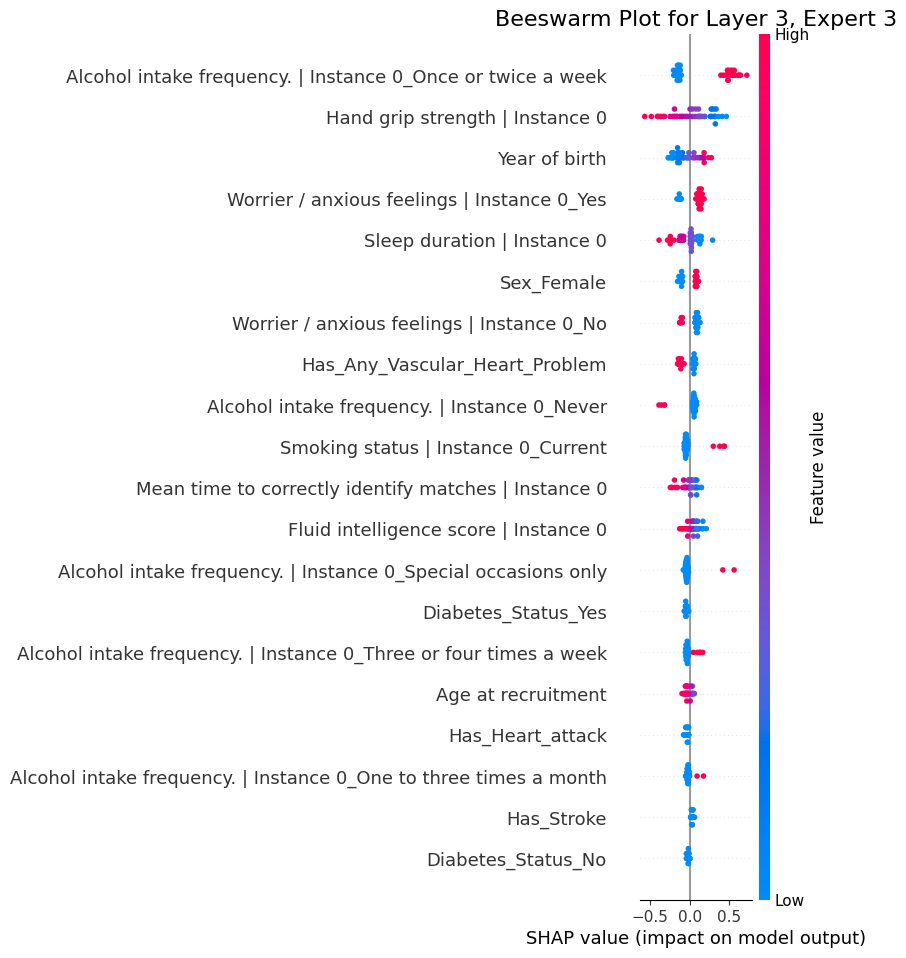


Mean Absolute SHAP Values (Layer 3, Expert 3)


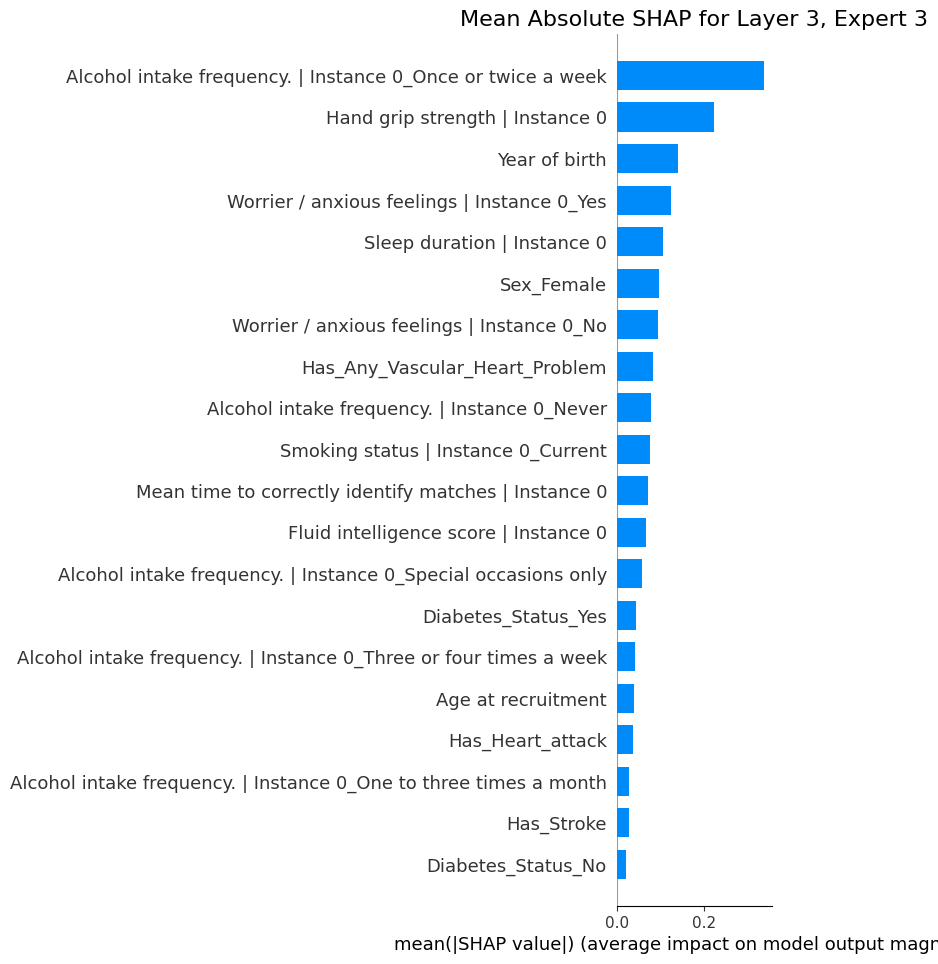

In [205]:
import shap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ===================================================================
# SHAP Analysis of the Final, Best Model and its Experts
# ===================================================================
print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis\n" + "="*40)

# --- 1. Prepare data for SHAP ---
# Assuming final_model, X_train_scaled, X_test_scaled, and X are already defined
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)
final_model.eval()

background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

# --- 2. SHAP Analysis for the OVERALL MoP Model ---
print("\n--- Analyzing Overall MoP Model ---")
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        self.model.train()
        pred, _, _ = self.model(x.unsqueeze(1))
        return pred.squeeze(1)

shap_model_wrapper = ShapModelWrapper(final_model)
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)
shap_values = explainer.shap_values(test_tensor)

# --- THIS IS THE FIX: Add titles to each plot ---

# Plot 1: Beeswarm Plot
print("\nSHAP Beeswarm Plot (Impact on each prediction)")
# Use show=False to prevent the plot from displaying immediately
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
# Add a title using matplotlib
plt.title("Overall Model: SHAP Beeswarm Plot", fontsize=16)
# Now, display the plot
plt.show()

# Plot 2: Bar Plot (Mean absolute values)
print("\nMean Absolute SHAP Values (Overall Importance)")
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Overall Model: Mean Absolute SHAP Values", fontsize=16)
plt.show()


# --- 3. Analyze what each expert focuses on ---
print("\n\n" + "="*40 + "\n🕵️ Analyzing Expert Specializations\n" + "="*40)

with torch.no_grad():
    # Get the intermediate activations and router weights
    intermediate_activations = [final_model.input_layer(test_tensor.unsqueeze(1))]
    router_weights = []

    for block in final_model.blocks:
        # The input to the block is the output of the previous layer
        block_input = intermediate_activations[-1]

        # Get the router weights for this block
        _, weights, _, _, _ = block.sparse_moe.router(block_input, torch.zeros_like(block_input[:,:,0], dtype=torch.long))
        router_weights.append(weights.squeeze(1).cpu().numpy())

        # Get the output of this block to be the input for the next
        block_output, _, _, _ = block(block_input, torch.zeros_like(block_input[:,:,0], dtype=torch.long))
        intermediate_activations.append(block_output)

# Now, plot the SHAP values for the data most relevant to each expert
for i, block_weights in enumerate(router_weights):
    for j in range(block_weights.shape[1]):
        # Skip identity experts
        if final_model.blocks[i].sparse_moe.experts[j].identity:
            continue

        print(f"\n--- SHAP Analysis for data routed to Layer {i+1}, Expert {j+1} ---")

        # Find the top 50 samples that this expert received the highest weight for
        top_samples_indices = np.argsort(block_weights[:, j])[-50:]

        # Select the corresponding SHAP values and test data for these top samples
        shap_subset = shap_values[1][top_samples_indices]
        X_test_subset = X_test_scaled[top_samples_indices]

        # Create the summary plots for this subset of data
        print(f"\nSHAP Beeswarm Plot (Layer {i+1}, Expert {j+1})")
        shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="dot", show=False)
        plt.title(f"Beeswarm Plot for Layer {i+1}, Expert {j+1}", fontsize=16)
        plt.show()

        print(f"\nMean Absolute SHAP Values (Layer {i+1}, Expert {j+1})")
        shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="bar", show=False)
        plt.title(f"Mean Absolute SHAP for Layer {i+1}, Expert {j+1}", fontsize=16)
        plt.show()


For each data point, you find which expert its assigned to based on the routing weights. The final output is filter based on these groups to get shap values for individual experts. 

The problem of applying shap to individual experts in MoP asks the question: How do the abstract neurons from the previous layer affect this expert's output?. It takes the intermediate, processed data from one layer and uses it as the "features" to explain the next layer. This makes it impossible to interpret since you get importance scores of the ouput of neurons from the previous layer. 